In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path
import os, sys, datetime, time, random, fnmatch, math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import skimage.metrics

import torch
from torchvision import transforms as tvtransforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.utils as vutils
import torch.utils.tensorboard as tensorboard
import torch.nn as nn

import datasets, transforms, RajaramanModel, pytorch_msssim

# Flags:
flag_saveReportPictures = False # set to True to produce a batch of example images for writing reports and papers
flag_saveSuppressedImages = False # set to True to produce images for further AI training

# Paths
PATH_SAVE_NETWORK_INTERMEDIATE = "./trained_network.tar"
key_source = "source" # this is the dictionary key for the original radiograph in the datasets
key_boneless = "boneless" # this is the dictionary key for the bone-suppressed radiograph in the datasets file
# Data
_batch_size = 8
image_spatial_size = (256,256)

switch = "internal_test"#"external_POLYU" #

print("The dataset chosen is: " + switch)

if switch == "internal_original":
    directory_source = "D:/data/JSRT/JSRT/"
    directory_boneless = "D:/data/JSRT/BSE_JSRT/"
    keys_images = [key_source, key_boneless]
    ds = datasets.JSRT_CXR(directory_source, directory_boneless, 
                           transform=tvtransforms.Compose([
                                 transforms.RescalingNormalisation(keys_images,(0,1)),
                                 transforms.Rescale(image_spatial_size, keys_images, None),
                                 transforms.ToTensor(keys_images),
                                 ]))
elif switch == "internal_test":
    directory_source = "D:/data/JSRT/augmented/test/source/"
    directory_boneless = "D:/data/JSRT/augmented/test/target/"
    keys_images = [key_source, key_boneless]
    ds = datasets.JSRT_CXR(directory_source, directory_boneless, 
                           transform=tvtransforms.Compose([
                                 transforms.RescalingNormalisation(keys_images,(0,1)),
                                 transforms.Rescale(image_spatial_size, keys_images, None),
                                 #transforms.RandomIntensityComplement(keys_images),
                                 transforms.ToTensor(keys_images),
                                 ]))
elif switch == "internal_NN":
    directory_source = "D:/data/JSRT/JSRT_NN/"
    directory_boneless = None
    keys_images = [key_source]
    ds = datasets.JSRT_CXR(directory_source, directory_boneless, 
                           transform=tvtransforms.Compose([
                                 transforms.RescalingNormalisation(keys_images,(0,1)),
                                 transforms.Rescale(image_spatial_size, keys_images, None),
                                 transforms.ToTensor(keys_images),
                                 ]))
    
elif switch == "external_POLYU":
    externalTest_directory = "D:/data/POLYU_COVID19_CXR_CT_Cohort1/cxr/CXR_PNG"
    keys_images = [key_source]
    ds = datasets.POLYU_COVID19_CXR_CT_Cohort1(externalTest_directory,
                                 transform=tvtransforms.Compose([
                                 transforms.RescalingNormalisation(keys_images,(0,1)),
                                 transforms.Rescale(image_spatial_size, keys_images, None),
                                 transforms.ToTensor(keys_images),
                                 ]))
else:
    raise RuntimeError("Dataset unknown.  Please input the details in the datasets.py file")
print(len(ds))
dl = DataLoader(ds, _batch_size, shuffle=False, num_workers=0)

# Select test 
sample = next(iter(dl))
print(sample[key_source].shape)

## Code for putting things on the GPU
ngpu = 1 #torch.cuda.device_count()
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
if (torch.cuda.is_available()):
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

The dataset chosen is: internal_test
80
torch.Size([8, 1, 256, 256])
cpu


In [2]:
# Network
input_array_size = (_batch_size, 1, image_spatial_size[0], image_spatial_size[1])
net = RajaramanModel.ResNet_BS(input_array_size)
#net = nn.DataParallel(net, list(range(ngpu)))
if os.path.isfile(PATH_SAVE_NETWORK_INTERMEDIATE):
    print("=> loading checkpoint '{}'".format(PATH_SAVE_NETWORK_INTERMEDIATE))
    checkpoint = torch.load(PATH_SAVE_NETWORK_INTERMEDIATE, map_location='cpu')
    start_epoch = checkpoint['epoch_next']
    reals_shown_now = checkpoint['reals_shown']
    net.load_state_dict(checkpoint['model_state_dict'])
    print("=> loaded checkpoint '{}' (epoch {}, reals shown {})".format(PATH_SAVE_NETWORK_INTERMEDIATE, 
                                                                        start_epoch, reals_shown_now))
else:
    print("=> NO CHECKPOINT FOUND AT '{}'" .format(PATH_SAVE_NETWORK_INTERMEDIATE))
    raise RuntimeError("No checkpoint found at specified path.")

net = net.to(device)
# Set to testing mode
net.eval()
print(".")

=> loading checkpoint './trained_network.tar'
=> loaded checkpoint './trained_network.tar' (epoch 200, reals shown 798400)
.


In [3]:
if flag_saveSuppressedImages:
    print("Saving a set of bone suppressed images")
    path_to_save_images = Path(os.path.join("bone_suppressed",switch))
    path_to_save_images.mkdir(parents=True, exist_ok=True)
    iters=0
    for ii, data in enumerate(dl):
        input_data = data[key_source].to(device)
        out = net(input_data)
        print(out.shape)
        print("Batch Number:" + str(ii))
        out = out.cpu()
        for image in out:
            savename = str(iters)+".png"
            vutils.save_image( image, os.path.join(path_to_save_images, savename))
            iters+=1
    print("Complete saving suppressed images")

.


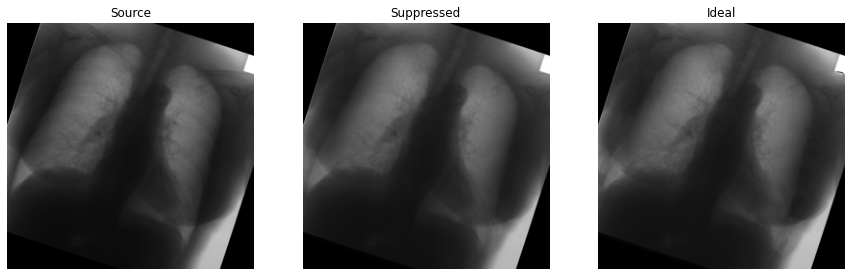

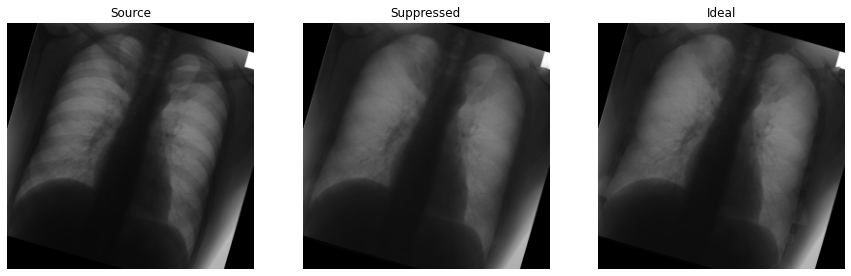

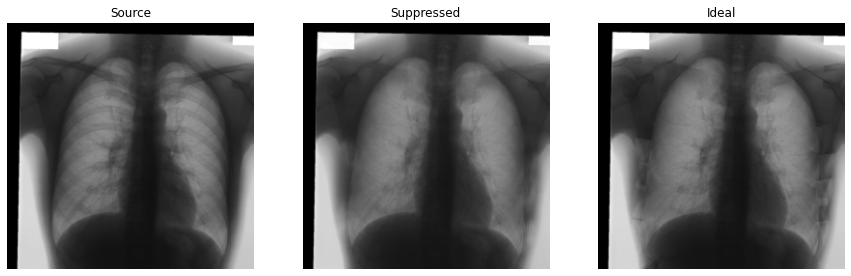

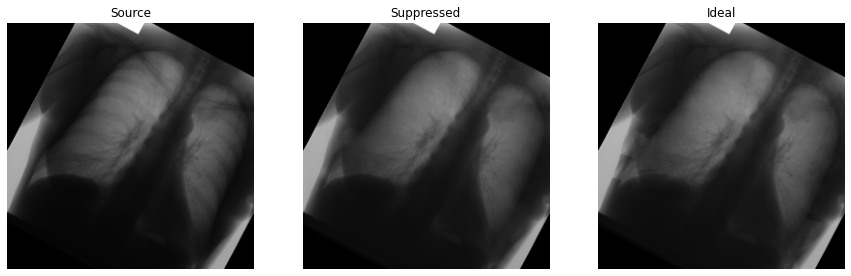

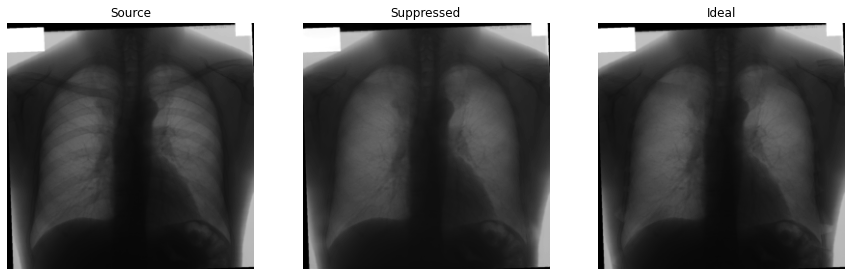

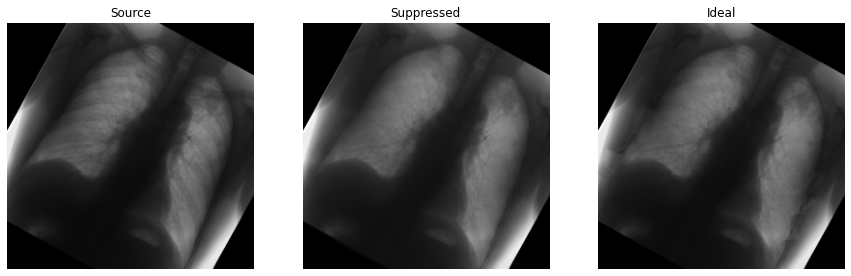

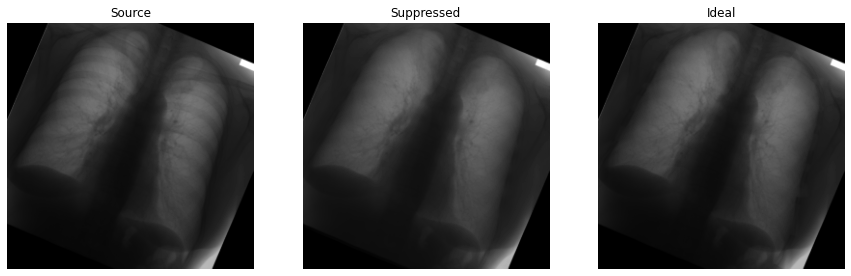

<Figure size 432x288 with 0 Axes>

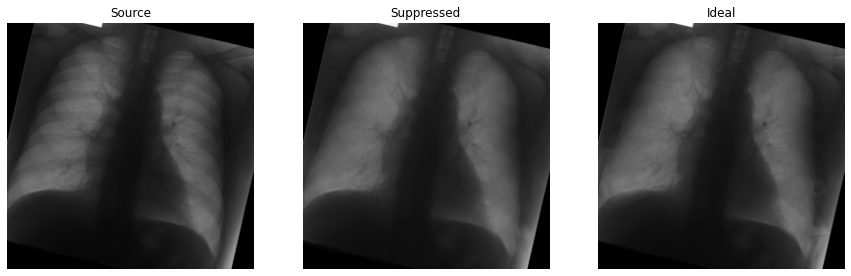

In [4]:
# Display
save_directory = os.path.split(PATH_SAVE_NETWORK_INTERMEDIATE)[0]
print(save_directory)

out = net(sample[key_source])
out = out.detach()
for batch_idx in range(_batch_size):
    if "boneless" in keys_images:
        plt.figure(1)
        fig, ax = plt.subplots(1,3, figsize=(15,5))
        ax[0].imshow(sample["source"][batch_idx,0,:],cmap='gray')
        ax[0].set_title("Source")
        ax[0].axis("off")
        ax[1].imshow(out[batch_idx,0,:],cmap='gray')
        ax[1].set_title("Suppressed")
        ax[1].axis("off")
        ax[2].imshow(sample["boneless"][batch_idx,0,:],cmap='gray')
        ax[2].set_title("Ideal")
        ax[2].axis("off")
    else:
        plt.figure(1)
        fig, ax = plt.subplots(1,2, figsize=(10,5))
        ax[0].imshow(sample["source"][batch_idx,0,:],cmap='gray')
        ax[0].set_title("Source")
        ax[0].axis("off")
        ax[1].imshow(out[batch_idx,0,:],cmap='gray')
        ax[1].set_title("Suppressed")
        ax[1].axis("off")
    if flag_saveReportPictures:
        plt.savefig(os.path.join(save_directory, switch + "_comparisonImages_"+ str(batch_idx) +".png"))

In [5]:
# Analysis
def PSNR(image, reference, max_reference=1.):
    """ 
    Peak Signal-to-Noise Ratio
    Input image and reference assumed to be Torch Tensors of shape [NxCxHxW]
    """
    # Assume the image 
    H = image.size(-2)
    W = image.size(-1)
    MSE = (1/(H*W))*torch.sum((torch.abs(image - reference))**2, (-1,-2))
    rtMSE = torch.sqrt(MSE)
    
    output = 20*torch.log10(max_reference/rtMSE)
    return output.numpy().squeeze()

def NPS():
    """Noise Power Spectrum"""
    

def SSIM(image, reference):
    iters = 0
    out_list = np.ndarray(image.size(0))
    for im in image:
        im = im.numpy()
        im = np.moveaxis(im, 0,-1)
        ref = reference[iters,:].numpy()
        ref = np.moveaxis(ref, 0,-1)
        out = skimage.metrics.structural_similarity(im, ref, multichannel=True)
        out_list[iters]=out
        iters+=1
    return out_list

def RMSE(image, reference):
    # Assume the image 
    H = image.size(-2)
    W = image.size(-1)
    MSE = (1/(H*W))*torch.sum((torch.abs(image - reference))**2, (-1,-2))
    RMSE = torch.sqrt(MSE)
    out_list = np.squeeze(RMSE.numpy())
    return out_list

psnr_dict={"source_to_boneless":[], "suppressed_to_boneless":[]}
ssim_dict={"source_to_boneless":[], "suppressed_to_boneless":[]}
RMSE_dict ={"source_to_boneless":[], "suppressed_to_boneless":[]}
if "boneless" in keys_images:
    for sample in dl:
        # Neural network
        out = net(sample["source"])
        out = out.detach()
        
        psnr_dict["source_to_boneless"].append(PSNR(sample["source"], sample["boneless"]))
        psnr_dict["suppressed_to_boneless"].append(PSNR(out, sample["boneless"]))
        ssim_dict["source_to_boneless"].append(SSIM(sample["source"], sample["boneless"]))
        ssim_dict["suppressed_to_boneless"].append(SSIM(out, sample["boneless"]))
        RMSE_dict["source_to_boneless"].append(RMSE(sample["source"], sample["boneless"]))
        RMSE_dict["suppressed_to_boneless"].append(RMSE(out, sample["boneless"]))
#print("PSNR original: {} ; after denoising: {} ".format(PSNR(sample["source"], sample["boneless"]).mean(), PSNR(out, sample["boneless"]).mean()))
#print("SSIM original: {} ; after denoising: {} ".format(SSIM(sample["source"], sample["boneless"]).mean(), SSIM(out, sample["boneless"]).mean()))
print(os.path.split(PATH_SAVE_NETWORK_INTERMEDIATE))

('.', 'trained_network.tar')


In [6]:
# Overall averaging
print("PSNR Source to Boneless: " + str(np.concatenate(psnr_dict["source_to_boneless"]).mean()) + "+/-" + str(np.std(np.concatenate(psnr_dict["source_to_boneless"]))))
print("PSNR Suppressed to Boneless: " + str(np.concatenate(psnr_dict["suppressed_to_boneless"]).mean()) + "+/-" + str(np.std(np.concatenate(psnr_dict["suppressed_to_boneless"]))))
print("SSIM Source to Boneless: " + str(np.concatenate(ssim_dict["source_to_boneless"]).mean()) + "+/-" + str(np.std(np.concatenate(ssim_dict["source_to_boneless"]))))
print("SSIM Suppressed to Boneless: " + str(np.concatenate(ssim_dict["suppressed_to_boneless"]).mean()) + "+/-" + str(np.std(np.concatenate(ssim_dict["suppressed_to_boneless"]))))
print("RMSE Source to Boneless: "+str(np.concatenate(RMSE_dict["source_to_boneless"]).mean()) +"+/-"+ str(np.std(np.concatenate(RMSE_dict["source_to_boneless"])))) 
print("RMSE Suppressed to Boneless: "+str(np.concatenate(RMSE_dict["suppressed_to_boneless"]).mean())+"+/-"+str(np.std(np.concatenate(RMSE_dict["suppressed_to_boneless"]))))

PSNR Source to Boneless: 31.256824+/-3.8574307
PSNR Suppressed to Boneless: 35.509766+/-4.588388
SSIM Source to Boneless: 0.9619104860446681+/-0.029896109073237892
SSIM Suppressed to Boneless: 0.9823579855699002+/-0.01930413143182238
RMSE Source to Boneless: 0.030244624+/-0.01420212
RMSE Suppressed to Boneless: 0.019478407+/-0.011682327


In [7]:
# Paired averaging
def paired_t_test(array1, array2):
    array1 = np.concatenate(array1)
    array2 = np.concatenate(array2)
    
    x_diff = array1 - array2
    s_diff = np.std(x_diff)
    x_diff_mean = np.mean(x_diff)
    s_x = s_diff/np.sqrt(len(x_diff))
    
    t_score = np.abs(x_diff_mean/s_x)
    return t_score

T_PSNR = paired_t_test(psnr_dict["source_to_boneless"], psnr_dict["suppressed_to_boneless"])
T_SSIM = paired_t_test(ssim_dict["source_to_boneless"], ssim_dict["suppressed_to_boneless"])
T_RMSE = paired_t_test(RMSE_dict["source_to_boneless"], RMSE_dict["suppressed_to_boneless"])

print(T_PSNR)
print(T_SSIM)
print(T_RMSE)

12.556283498431252
7.915196536774192
11.270607749530862
